In [1]:
# !pip install scikit-optimize
# from google.colab import drive
# drive.mount('/content/drive')

# Imports

In [1]:
import time
import timeit
import math

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', message='The objective has been evaluated at point')
warnings.filterwarnings('ignore', message='invalid value encountered in cast')

from IPython.display import display

from functools import reduce
from operator import mul

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import pearsonr, probplot, shapiro, kstest, norm, anderson, skew, kurtosis

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from scipy.stats import ttest_rel

# Data

## Importing and cleaning

In [2]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/car_data.csv')
data = pd.read_csv('data/car_data.csv')

In [3]:
display(data.head())
print()
display(data.describe(include='all'))
print()
print('Null values')
display(data.isnull().sum().sort_values())
print()
print('Unique values')
display(data.nunique().sort_values())

,Price,Year,Generation,Trim,Mileage,Distance,Seller
0,5995,2017,7,ST-3,102857,7,Private
1,11995,2017,7,ST-3,30100,21,Trade
2,14295,2019,8,ST-3,42150,26,Trade
3,10800,2017,7,ST-3,46000,29,Trade
4,21495,2022,8,ST-3,10000,29,Trade


,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635,635.000000,635.000000,635
unique,NaN,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,NaN,ST-3,NaN,NaN,Trade
freq,NaN,NaN,NaN,364,NaN,NaN,497
mean,11913.724409,2016.223622,7.464567,NaN,47636.426772,175.433071,NaN
std,5391.029049,36.549181,0.499136,NaN,27875.479021,71.853842,NaN
min,3030.000000,1100.000000,7.000000,NaN,9.000000,7.000000,NaN
25%,7487.500000,2015.000000,7.000000,NaN,23339.000000,135.000000,NaN
50%,10000.000000,2017.000000,7.000000,NaN,47000.000000,174.000000,NaN
75%,15992.500000,2020.000000,8.000000,NaN,67664.000000,208.000000,NaN



Null values


Price         0
Year          0
Generation    0
Trim          0
Mileage       0
Distance      0
Seller        0
dtype: int64


Unique values


Generation      2
Trim            2
Seller          2
Year           14
Distance      222
Price         400
Mileage       507
dtype: int64

In [4]:
# Generation: 7 to 1, 8 to 0 (i.e. mine is 1)
# Trim: ST-3 to 1, ST-2 to 0 (i.e. mine is 1)
# Seller: Private to 1, trade to 0 (i.e. mine is 1)

data['Generation'] = data['Generation'].map({7:1, 8:0})
data['Trim'] = data['Trim'].map({'ST-3':1, 'ST-2':0})
data['Seller'] = data['Seller'].map({'Private':1, 'Trade':0})

display(data.describe(include='all'))

,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,11913.724409,2016.223622,0.535433,0.573228,47636.426772,175.433071,0.217323
std,5391.029049,36.549181,0.499136,0.494998,27875.479021,71.853842,0.412749
min,3030.000000,1100.000000,0.000000,0.000000,9.000000,7.000000,0.000000
25%,7487.500000,2015.000000,0.000000,0.000000,23339.000000,135.000000,0.000000
50%,10000.000000,2017.000000,1.000000,1.000000,47000.000000,174.000000,0.000000
75%,15992.500000,2020.000000,1.000000,1.000000,67664.000000,208.000000,0.000000
max,26950.000000,2025.000000,1.000000,1.000000,164530.000000,462.000000,1.000000


In [5]:
def boxplot_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Boxplots for {title}', fontsize=16)
    numeric_columns = data.select_dtypes(include=['number']).columns
    for i, column in enumerate(numeric_columns):
        plt.subplot(2, 4, i + 1)
        data.boxplot(column=[column])
        plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

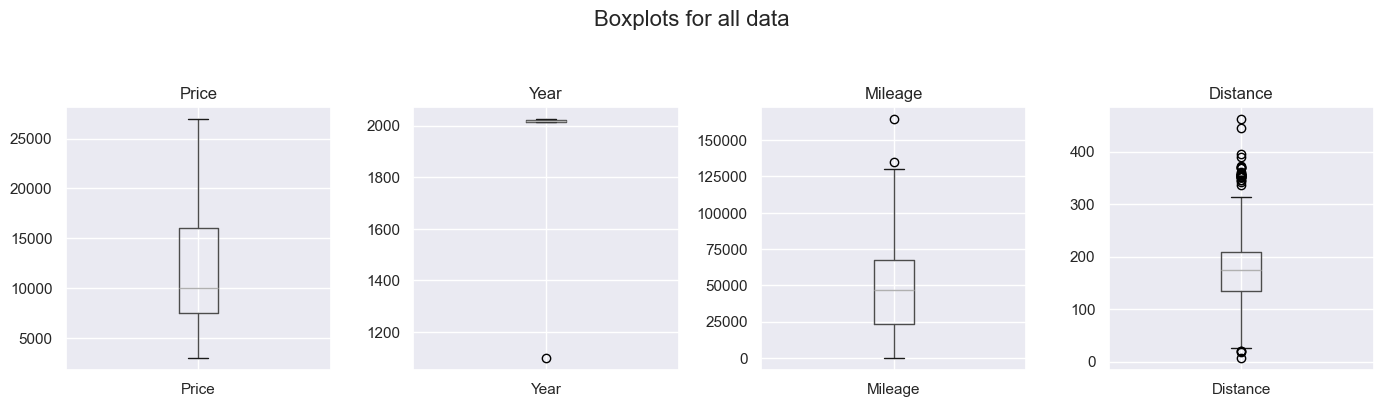

In [6]:
boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')

In [ ]:
# Fixed outlier values come from manually checking raw data

data[data['Year'] == 1100]
data.loc[17, 'Year'] = 2020

data[data['Year'] == 2025]
data.loc[80, 'Year'] = 2016
data.loc[110, 'Year'] = 2019

data['Mileage'].sort_values().tail()
data.drop(index=53, inplace=True)

boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')

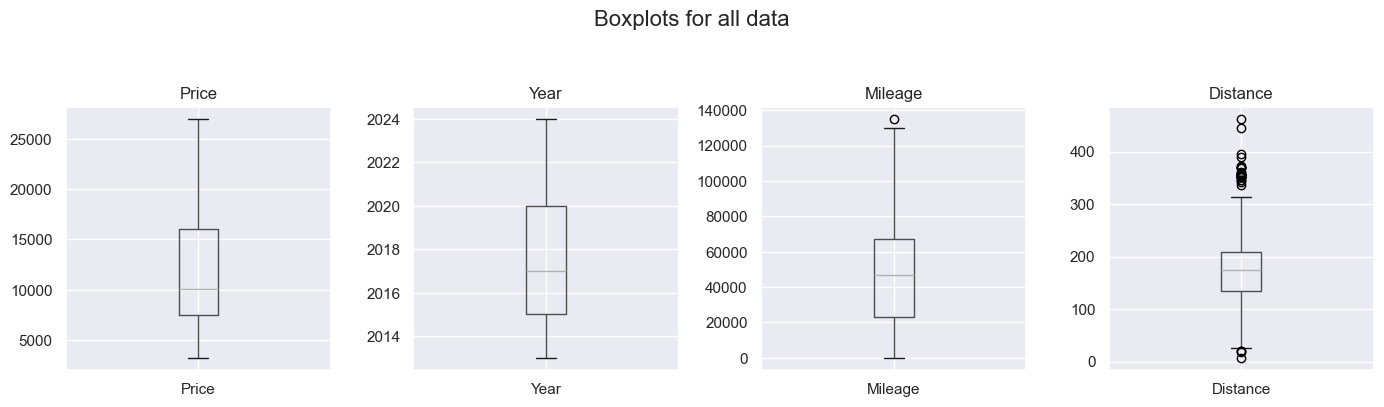

In [8]:
boxplot_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')

In [8]:
display(data.describe(include='all'))

,Price,Year,Generation,Trim,Mileage,Distance,Seller
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,11927.736593,2017.654574,0.534700,0.572555,47452.052050,175.526814,0.216088
std,5383.700767,3.084731,0.499188,0.495098,27507.263954,71.871705,0.411900
min,3250.000000,2013.000000,0.000000,0.000000,9.000000,7.000000,0.000000
25%,7490.000000,2015.000000,0.000000,0.000000,23169.500000,135.000000,0.000000
50%,10097.500000,2017.000000,1.000000,1.000000,47000.000000,174.500000,0.000000
75%,15993.750000,2020.000000,1.000000,1.000000,67478.500000,208.000000,0.000000
max,26950.000000,2024.000000,1.000000,1.000000,135000.000000,462.000000,1.000000


## Data splitting

In [9]:
# Data split by categories (generation, trim, seller type)

st3_data = data[data['Trim'] == 1]
st3_data_dropped = st3_data.loc[:, st3_data.nunique() != 1]

gen7_data = data[data['Generation'] == 1]

gen7_st3_data = gen7_data[gen7_data['Trim'] == 1]
gen7_st2_data = gen7_data[gen7_data['Trim'] == 0]

gen7_private_data = gen7_data[gen7_data['Seller'] == 1]
gen7_trade_data = gen7_data[gen7_data['Seller'] == 0]

gen7_st3_private_data = gen7_st3_data[gen7_st3_data['Seller'] == 1]
gen7_st3_trade_data = gen7_st3_data[gen7_st3_data['Seller'] == 0]

gen7_st2_private_data = gen7_st2_data[gen7_st2_data['Seller'] == 1]
gen7_st2_trade_data = gen7_st2_data[gen7_st2_data['Seller'] == 0]

gen8_data = data[data['Generation'] == 0]

gen8_st3_data = gen8_data[gen8_data['Trim'] == 1]
gen8_st2_data = gen8_data[gen8_data['Trim'] == 0]

gen8_private_data = gen8_data[gen8_data['Seller'] == 1]
gen8_trade_data = gen8_data[gen8_data['Seller'] == 0]

gen8_st3_private_data = gen8_st3_data[gen8_st3_data['Seller'] == 1]
gen8_st3_trade_data = gen8_st3_data[gen8_st3_data['Seller'] == 0]

gen8_st2_private_data = gen8_st2_data[gen8_st2_data['Seller'] == 1]
gen8_st2_trade_data = gen8_st2_data[gen8_st2_data['Seller'] == 0]

# gen7_st3_private_data_dropped = gen7_st3_private_data.drop(['Generation', 'Trim', 'Seller'], axis=1) # these are effectively equivalent
gen7_st3_private_data_dropped = gen7_st3_private_data.loc[:, gen7_st3_private_data.nunique() != 1]


# Exploratory data analysis

## Price graphs

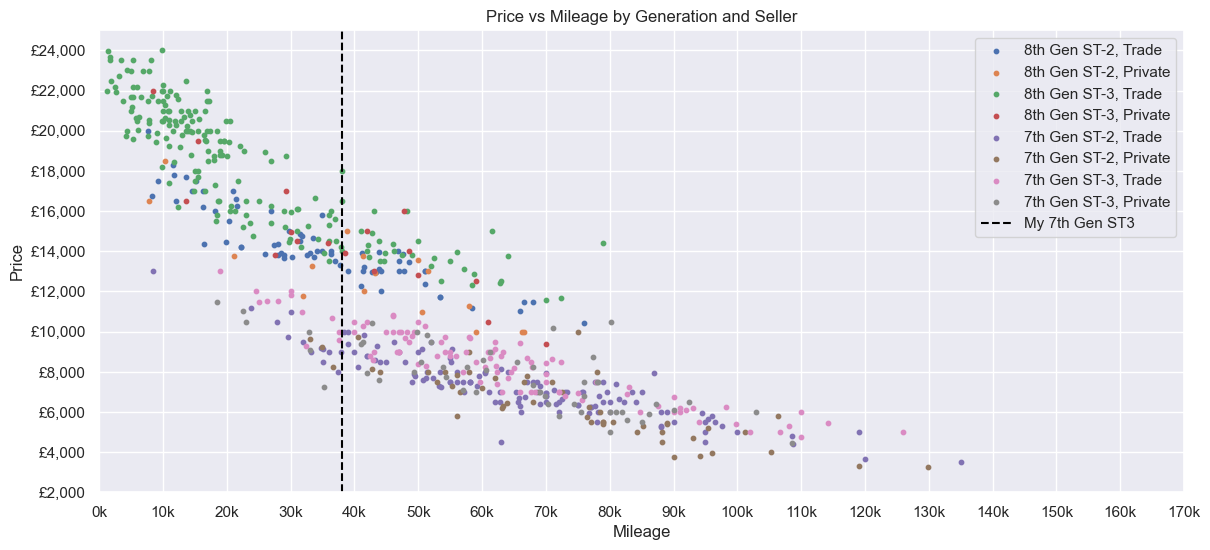

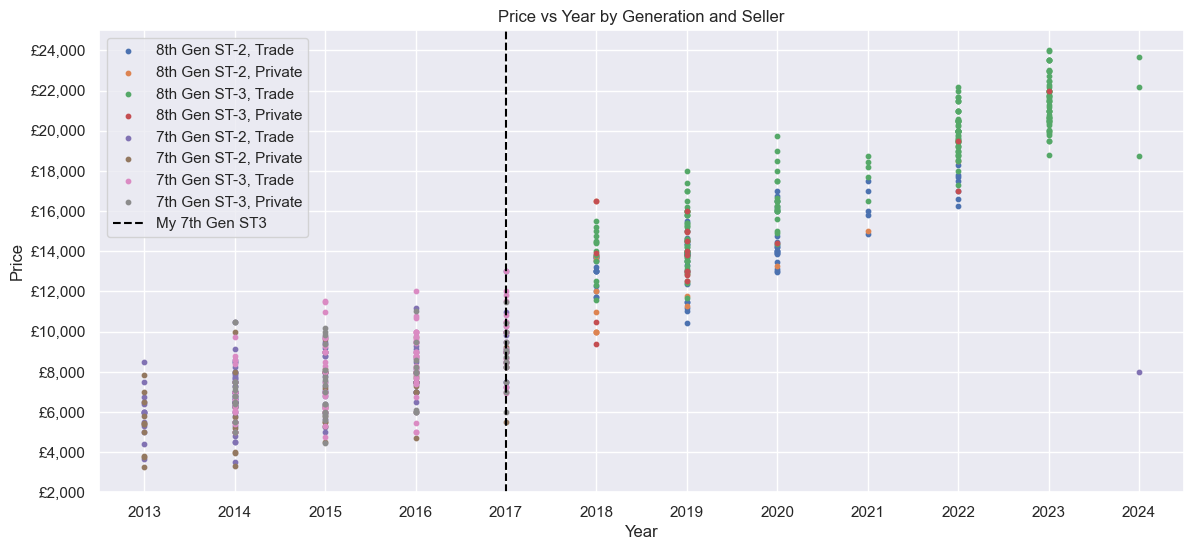

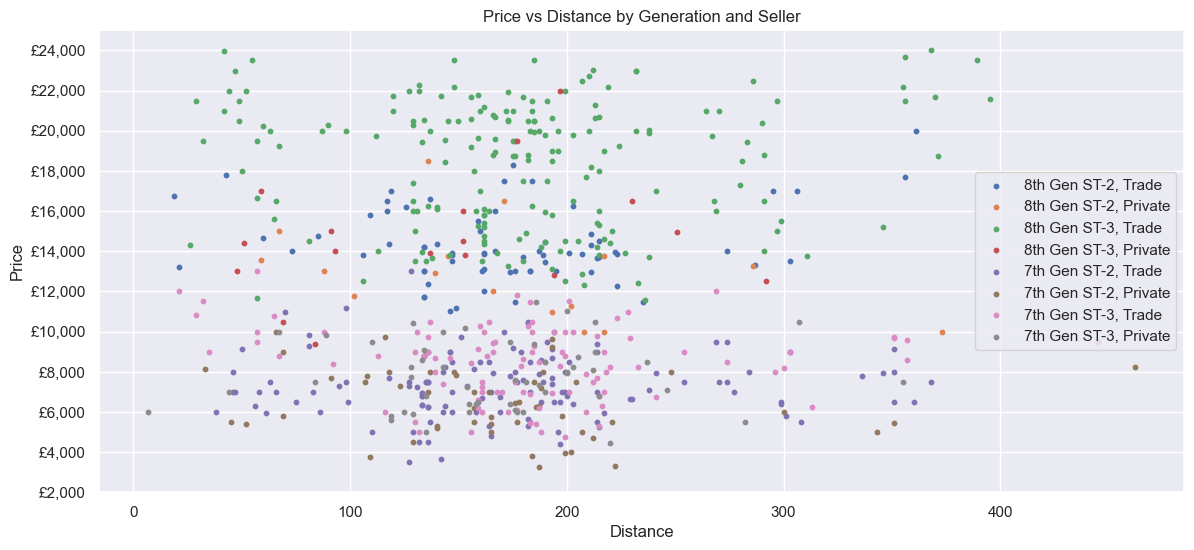

In [10]:
def plot_price_vs(x_col):
    plt.figure(figsize=(14, 6))
    plt.title(f'Price vs {x_col} by Generation and Seller')

    y_gen7_st2_private = gen7_st2_private_data['Price']
    y_gen7_st2_trade = gen7_st2_trade_data['Price']
    x_gen7_st2_private = gen7_st2_private_data[x_col]
    x_gen7_st2_trade = gen7_st2_trade_data[x_col]

    y_gen7_st3_private = gen7_st3_private_data['Price']
    y_gen7_st3_trade = gen7_st3_trade_data['Price']
    x_gen7_st3_private = gen7_st3_private_data[x_col]
    x_gen7_st3_trade = gen7_st3_trade_data[x_col]

    y_gen8_st2_private = gen8_st2_private_data['Price']
    y_gen8_st2_trade = gen8_st2_trade_data['Price']
    x_gen8_st2_private = gen8_st2_private_data[x_col]
    x_gen8_st2_trade = gen8_st2_trade_data[x_col]

    y_gen8_st3_private = gen8_st3_private_data['Price']
    y_gen8_st3_trade = gen8_st3_trade_data['Price']
    x_gen8_st3_private = gen8_st3_private_data[x_col]
    x_gen8_st3_trade = gen8_st3_trade_data[x_col]

    plt.scatter(x_gen8_st2_trade, y_gen8_st2_trade, s=10, label='8th Gen ST-2, Trade')
    plt.scatter(x_gen8_st2_private, y_gen8_st2_private, s=10, label='8th Gen ST-2, Private')

    plt.scatter(x_gen8_st3_trade, y_gen8_st3_trade, s=10, label='8th Gen ST-3, Trade')
    plt.scatter(x_gen8_st3_private, y_gen8_st3_private, s=10, label='8th Gen ST-3, Private')

    plt.scatter(x_gen7_st2_trade, y_gen7_st2_trade, s=10, label='7th Gen ST-2, Trade')
    plt.scatter(x_gen7_st2_private, y_gen7_st2_private, s=10, label='7th Gen ST-2, Private')

    plt.scatter(x_gen7_st3_trade, y_gen7_st3_trade, s=10, label='7th Gen ST-3, Trade')
    plt.scatter(x_gen7_st3_private, y_gen7_st3_private, s=10, label='7th Gen ST-3, Private')

    if x_col == 'Mileage':
        plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
    elif x_col == 'Year':
        plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

    ax = plt.gca()

    plt.ylabel('Price')
    plt.ylim(2000,25000)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))
    def currency_formatter(y, pos):
        return '£{:,.0f}'.format(y)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

    plt.xlabel(f'{x_col}')
    if x_col == 'Mileage':
      plt.xlim(0,170000)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
      def thousands_formatter(x, pos):
          return '{:.0f}k'.format(x / 1000)
      ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    elif x_col == 'Year':
      plt.xlim(2012.5, 2024.5)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.grid(True)
    plt.legend()
    plt.show()

plot_price_vs('Mileage')
plot_price_vs('Year')
plot_price_vs('Distance')

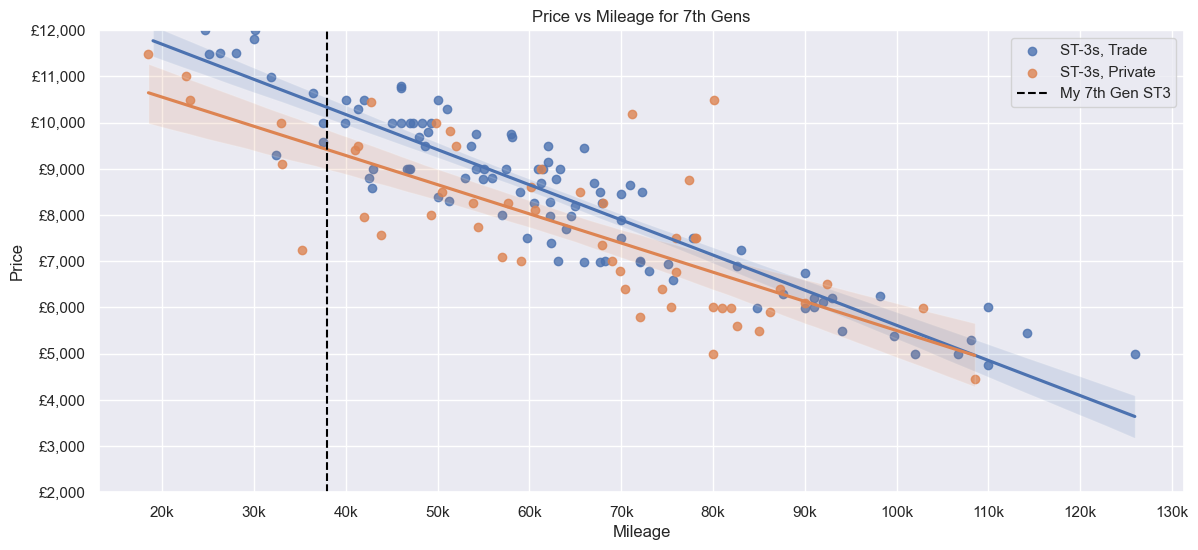

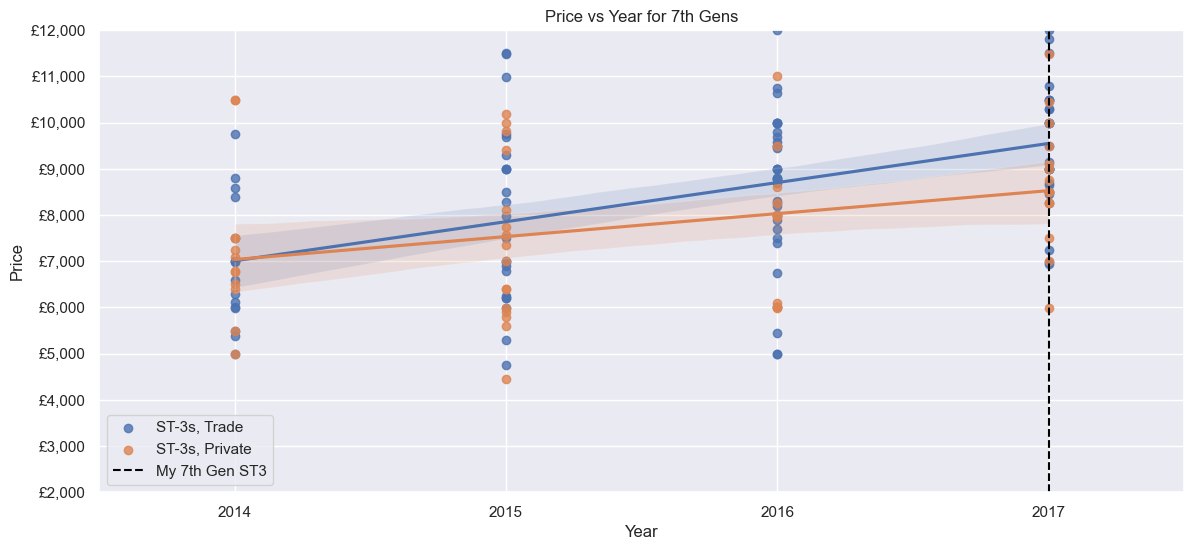

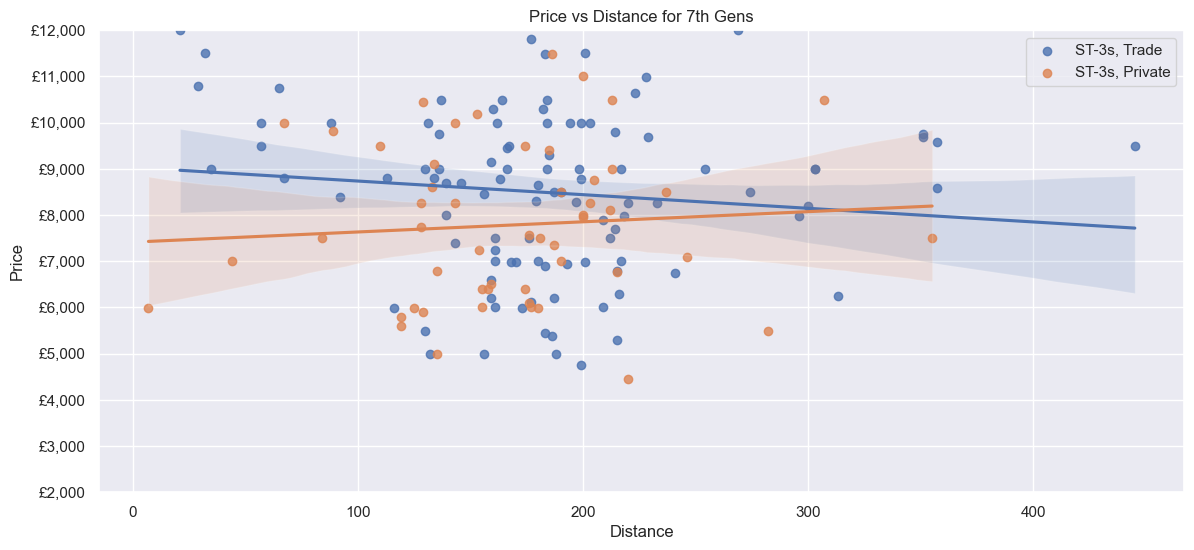

In [11]:
def plot_price_vs_gen7(x_col):
  plt.figure(figsize=(14, 6))
  plt.title(f'Price vs {x_col} for 7th Gens')

  ax = sns.regplot(data=gen7_st3_trade_data, x=x_col, y='Price', label='ST-3s, Trade')
  ax = sns.regplot(data=gen7_st3_private_data, x=x_col, y='Price', label='ST-3s, Private')

  if x_col == 'Mileage':
      plt.axvline(38000, color='black', linestyle='--', label='My 7th Gen ST3')
  elif x_col == 'Year':
      plt.axvline(2017, color='black', linestyle='--', label='My 7th Gen ST3')

  plt.ylabel('Price')
  plt.ylim(2000, 12000)
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
  def currency_formatter(y, pos):
      return '£{:,.0f}'.format(y)
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(currency_formatter))

  plt.xlabel(f'{x_col}')
  if x_col == 'Mileage':
    # plt.xlim(10000, 170000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10000))
    def thousands_formatter(x, pos):
        return '{:.0f}k'.format(x / 1000)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
  elif x_col == 'Year':
    plt.xlim(2013.5, 2017.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.grid(True)
  plt.legend()
  plt.show()

plot_price_vs_gen7('Mileage')
plot_price_vs_gen7('Year')
plot_price_vs_gen7('Distance')

## Histograms

In [11]:
def histogram_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Histograms for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      sns.histplot(data[column], kde=True)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

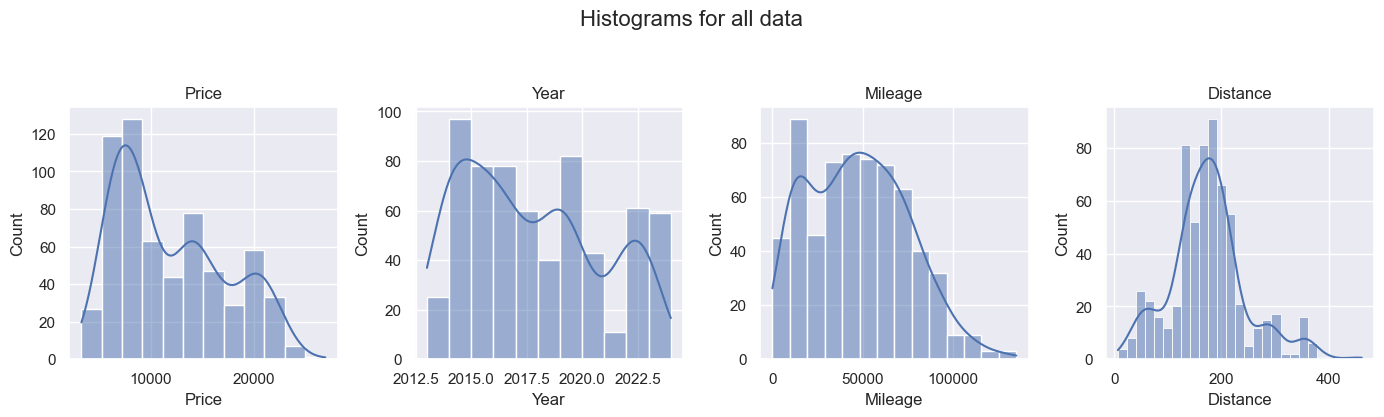

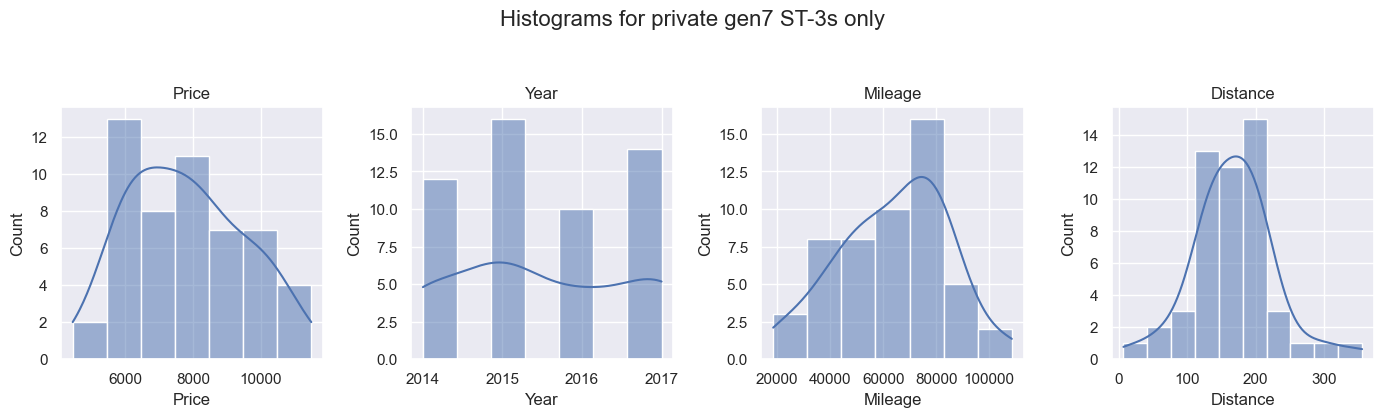

In [12]:
histogram_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')
histogram_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Q-Q plots

In [13]:
def qq_all_columns(data, title):
    plt.figure(figsize=(14, 7))
    plt.suptitle(f'Q-Q plots for {title}', fontsize=16)
    for i, column in enumerate(data.columns):
      plt.subplot(2,4,i+1)
      probplot(data[column], dist="norm", plot=plt)
      plt.title(column)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

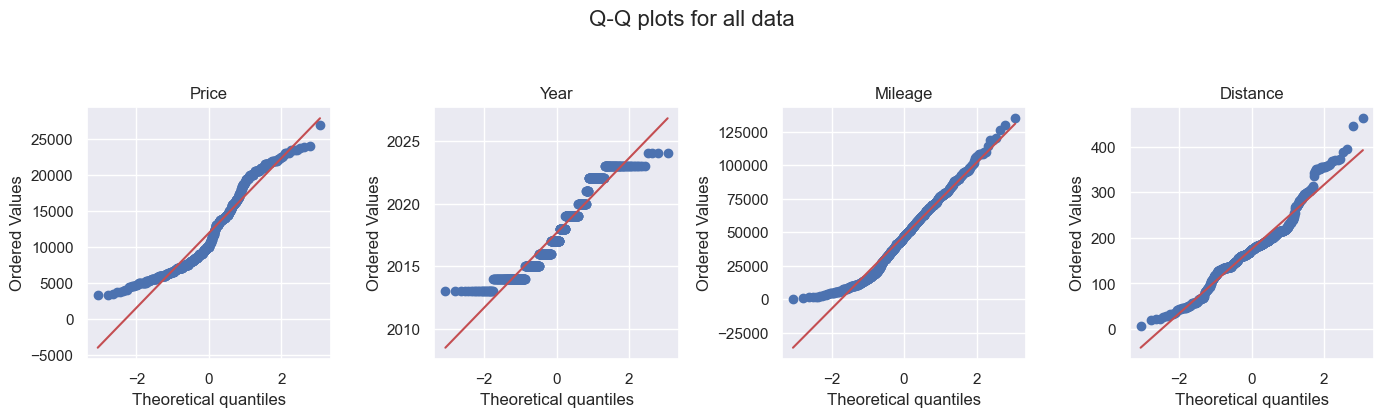

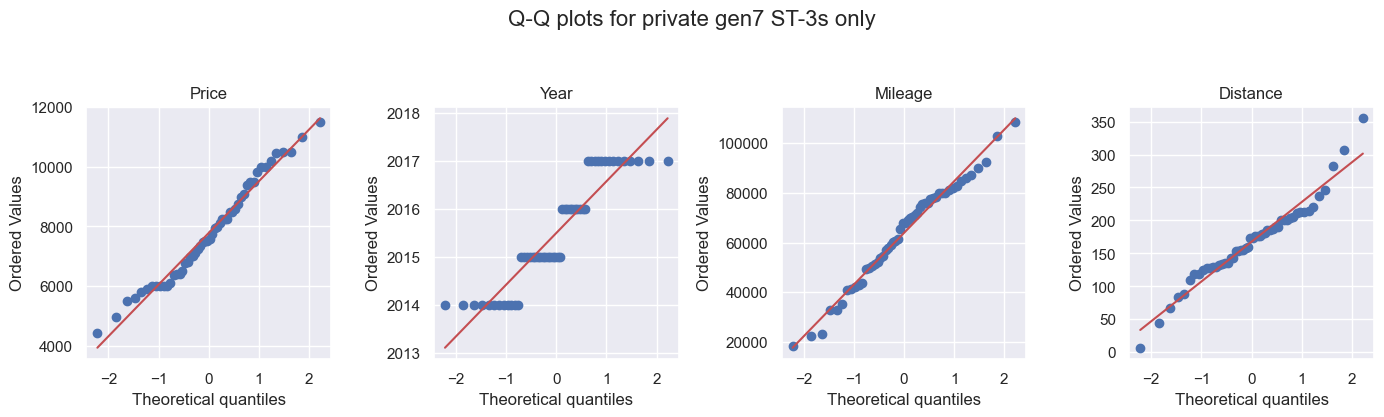

In [14]:
qq_all_columns(data[['Price', 'Year', 'Mileage', 'Distance']], 'all data')
qq_all_columns(gen7_st3_private_data_dropped, 'private gen7 ST-3s only')

## Normality statistics

In [16]:
def normality_all_columns(data):
    results = []
    for column in data.columns:
      stat_s, p_s = shapiro(data[column])
      stat_ks, p_ks = kstest(data[column], 'norm', args=(data[column].mean(), data[column].std()))
      skewness = skew(data[column])
      kurt = kurtosis(data[column])
      results.append({'Feature': column,
                      'Shapiro statistic': round(stat_s,3), 'Shapiro p-value': round(p_s,3),
                      'KS statistic': round(stat_ks,3), 'KS p-value': round(p_ks,3),
                      'Skew': round(skewness,3), 'Kurtosis': round(kurt,3)})
    results_df = pd.DataFrame(results)
    return results_df

In [17]:
display(normality_all_columns(data))
display(normality_all_columns(gen7_st3_private_data_dropped))

,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.929,0.0,0.140,0.000,0.532,-0.904
1,Year,0.926,0.0,0.143,0.000,0.351,-1.085
2,Generation,0.635,0.0,0.359,0.000,-0.139,-1.981
3,Trim,0.629,0.0,0.379,0.000,-0.293,-1.914
4,Mileage,0.975,0.0,0.064,0.011,0.320,-0.516
5,Distance,0.961,0.0,0.104,0.000,0.575,1.074
6,Seller,0.507,0.0,0.484,0.000,1.380,-0.097


,Feature,Shapiro statistic,Shapiro p-value,KS statistic,KS p-value,Skew,Kurtosis
0,Price,0.973,0.283,0.082,0.845,0.265,-0.804
1,Year,0.851,0.000,0.210,0.018,0.083,-1.360
2,Mileage,0.980,0.538,0.098,0.669,-0.255,-0.429
3,Distance,0.964,0.117,0.101,0.632,0.298,1.562


## Correlations

In [18]:
def correlate(data, type):
    corr = data.corr(method=type)
    display(corr)
    plot_corr(corr)

def plot_corr(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.color_palette("Spectral", as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True)
    plt.show()

,Price,Year,Generation,Trim,Mileage,Distance,Seller
Price,1.000000,0.941650,-0.859152,0.420945,-0.886435,0.028505,-0.312114
Year,0.941650,1.000000,-0.861673,0.390371,-0.793773,0.016833,-0.273131
Generation,-0.859152,-0.861673,1.000000,-0.249905,0.693170,-0.009449,0.236227
Trim,0.420945,0.390371,-0.249905,1.000000,-0.304463,0.040346,-0.073129
Mileage,-0.886435,-0.793773,0.693170,-0.304463,1.000000,-0.013497,0.269382
Distance,0.028505,0.016833,-0.009449,0.040346,-0.013497,1.000000,-0.070556
Seller,-0.312114,-0.273131,0.236227,-0.073129,0.269382,-0.070556,1.000000


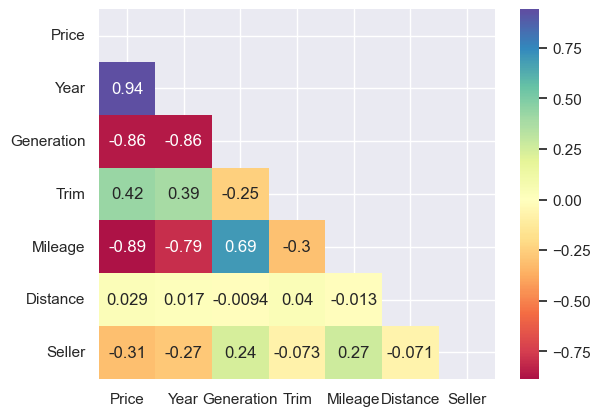

In [19]:
correlate(data, 'pearson')
# correlate(data, 'kendall')
# correlate(data, 'spearman')

,Price,Year,Mileage,Distance
Price,1.000000,0.329364,-0.759532,0.077803
Year,0.329364,1.000000,-0.228523,-0.087804
Mileage,-0.759532,-0.228523,1.000000,0.006719
Distance,0.077803,-0.087804,0.006719,1.000000


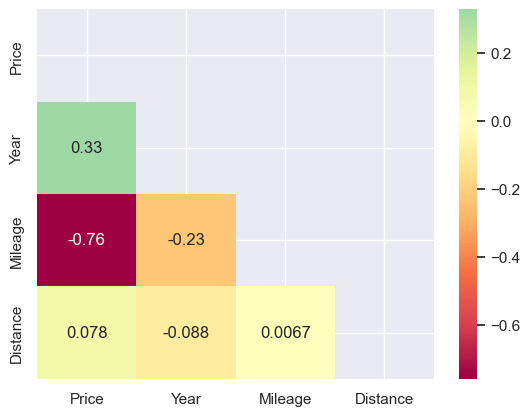

In [20]:
correlate(gen7_st3_private_data_dropped, 'pearson')
# correlate(gen7_st3_private_data_dropped, 'kendall')
# correlate(gen7_st3_private_data_dropped, 'spearman')

### Variance inflation factors

In [21]:
def calculate_vif(variables):
    vif_data = pd.DataFrame()
    vif_data["Features"] = variables.columns
    vif_data["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    return vif_data

In [22]:
display(calculate_vif(data[['Year', 'Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]))
display(calculate_vif(data[['Generation', 'Trim', 'Mileage', 'Distance', 'Seller']]))

,Features,VIF
0,Year,12.885280
1,Generation,4.172482
2,Trim,2.592994
3,Mileage,8.118682
4,Distance,7.019852
5,Seller,1.389587


,Features,VIF
0,Generation,4.169124
1,Trim,2.036742
2,Mileage,6.469743
3,Distance,3.861113
4,Seller,1.384422


## Clustering

### Price vs Mileage

In [20]:
data_only_price_and_mileage = data[['Price','Mileage']].copy()
data_only_price_and_mileage_scaled = scale(data_only_price_and_mileage)

In [19]:
def plot_elbow(data):
    wcss =[]
    for i in range(1,6):
        kmeans = KMeans(i)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1,6),wcss)
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

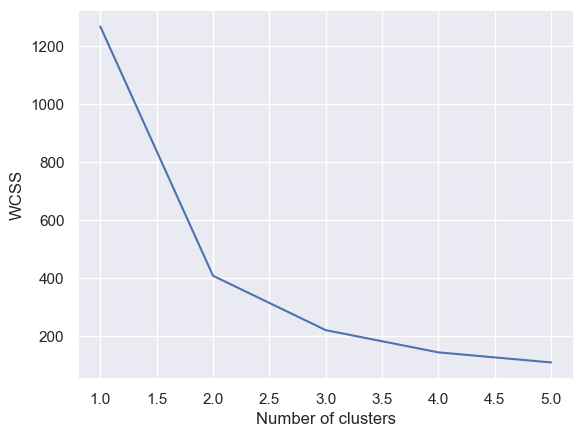

In [25]:
plot_elbow(data_only_price_and_mileage_scaled)

In [16]:
def plot_kmeans(data, data_scaled, x, y, n):
    kmeans = KMeans(n)
    clusters = kmeans.fit_predict(data_scaled)
    plt.scatter(data[x], data[y], c=clusters, cmap='rainbow')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

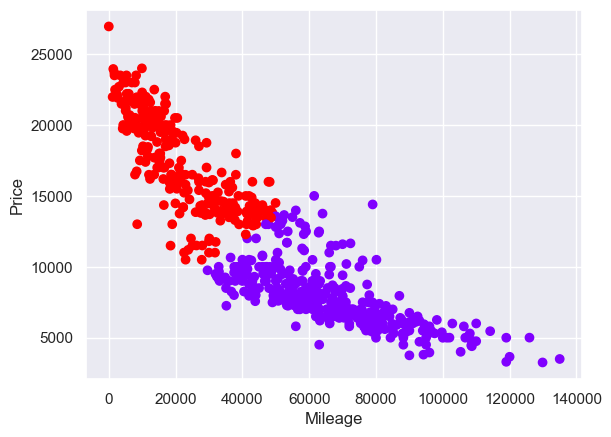

In [27]:
plot_kmeans(data_only_price_and_mileage, data_only_price_and_mileage_scaled, 'Mileage', 'Price', 2)

### Price vs Distance

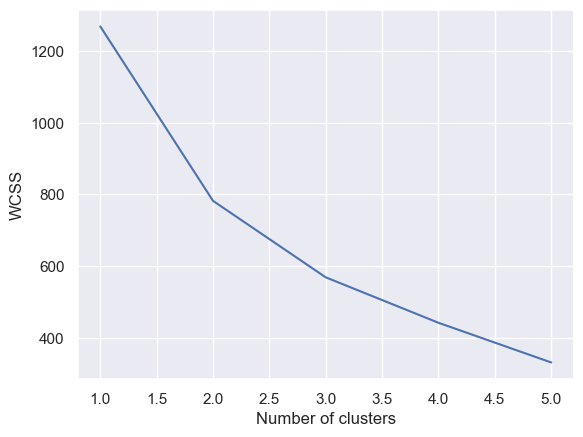

In [21]:
data_only_price_and_distance = data[['Price','Distance']].copy()
data_only_price_and_distance_scaled = scale(data_only_price_and_distance)

plot_elbow(data_only_price_and_distance_scaled)

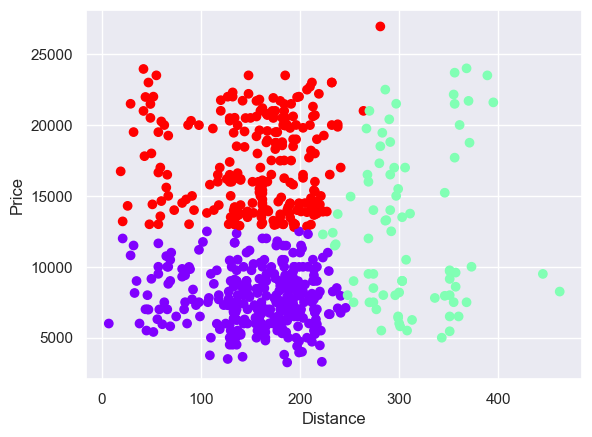

None

In [28]:
display(plot_kmeans(data_only_price_and_distance, data_only_price_and_distance_scaled, 'Distance', 'Price', 3))

# Simple modelling for privately-sold generation 7 ST-3s

## Data

In [30]:
data_simple = gen7_st3_private_data_dropped.copy()
# data_simple.describe()

X_simple = data_simple.copy()
X_simple = X_simple.drop(['Price'], axis=1)
y_simple = data_simple.copy()
y_simple = y_simple['Price']

mine_simple = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000],
    'Distance': [1]
})

scaler = StandardScaler()
X_simple_scaled = scaler.fit_transform(X_simple)

## OLS to check for insignificant features

In [31]:
def ols(dataset, xs, pred, title):
    print(title)
    print()
    y = dataset['Price']
    x1 = dataset[xs]
    x = sm.add_constant(x1)
    model_ols = sm.OLS(y,x).fit()
    p = sm.add_constant(pred, has_constant='add')
    predictions = model_ols.predict(p)
    print(f'Prediction: £{int(predictions[0])}')
    print()
    return model_ols.summary()

In [32]:
ols(data_simple, ['Year', 'Mileage', 'Distance'], mine_simple, 'OLS for gen7 ST-3 private data')

OLS for gen7 ST-3 private data

Prediction: £9262



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     25.24
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           6.03e-10
Time:                        06:47:14   Log-Likelihood:                -435.55
No. Observations:                  52   AIC:                             879.1
Df Residuals:                      48   BIC:                             886.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.157e+05   2.82e+05     -1.828      0.074   -1.08e+06    5.14e+04
Year         261.4098    139.866      1.869      0.068     -19.811     542.630
Mileage       -0.0599      0.008     -7.802      0.000      -0.075      -0.044
Distance       2.7670      2.552      1.084      0.284      -2.365       7.899
==============================================================================
Omnibus:                       15.834   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.808
Skew:                           1.119   Prob(JB):                     5.00e-05
Kurtosis:                       5.033   Cond. No.                     1.25e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Remove distance as insignificant

In [33]:
data_simple_no_distance = data_simple.copy()
data_simple_no_distance = data_simple_no_distance.drop(['Distance'], axis=1)

X_simple_no_distance = data_simple_no_distance.copy()
X_simple_no_distance = X_simple_no_distance.drop(['Price'], axis=1)
y_simple_no_distance = data_simple_no_distance.copy()
y_simple_no_distance = y_simple_no_distance['Price']

scaler_no_distance = StandardScaler()
X_simple_no_distance_scaled = scaler_no_distance.fit_transform(X_simple_no_distance)

mine_simple_no_distance = pd.DataFrame({
    'Year': [2017],
    'Mileage': [38000]
})

In [34]:
ols(data_simple_no_distance, ['Year', 'Mileage'], mine_simple_no_distance, 'Gen7 ST-3 private data, no distance')

Gen7 ST-3 private data, no distance

Prediction: £9706



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     37.13
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           1.53e-10
Time:                        06:47:14   Log-Likelihood:                -436.18
No. Observations:                  52   AIC:                             878.4
Df Residuals:                      49   BIC:                             884.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.882e+05   2.81e+05     -1.735      0.089   -1.05e+06    7.73e+04
Year         247.9726    139.565      1.777      0.082     -32.494     528.440
Mileage       -0.0600      0.008     -7.804      0.000      -0.075      -0.045
==============================================================================
Omnibus:                       20.424   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.195
Skew:                           1.249   Prob(JB):                     6.19e-08
Kurtosis:                       6.014   Cond. No.                     1.24e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## VIF to check for covariation

In [35]:
calculate_vif(data_simple_no_distance[['Year', 'Mileage']])

,Features,VIF
0,Year,10.900101
1,Mileage,10.900101


## Basic linear regressions

In [36]:
# Unsplit_no_distance

model_lr_simple_unsplit_no_distance = LinearRegression()
model_lr_simple_unsplit_no_distance.fit(X_simple_no_distance, y_simple_no_distance)
model_lr_simple_unsplit_no_distance_prediction = model_lr_simple_unsplit_no_distance.predict(mine_simple_no_distance)[0]

# split_no_distance

X_simple_no_distance_train, X_simple_no_distance_test, y_simple_no_distance_train, y_simple_no_distance_test = train_test_split(X_simple_no_distance, y_simple_no_distance, test_size=0.1, random_state=42)

model_lr_simple_split_no_distance = LinearRegression()
model_lr_simple_split_no_distance.fit(X_simple_no_distance_train, y_simple_no_distance_train)

model_lr_simple_split_no_distance_predictions = model_lr_simple_split_no_distance.predict(X_simple_no_distance_test).astype(int)
mae_lr_simple_split_no_distance = mean_absolute_error(y_simple_no_distance_test, model_lr_simple_split_no_distance_predictions)
mse_lr_simple_split_no_distance = mean_squared_error(y_simple_no_distance_test, model_lr_simple_split_no_distance_predictions)

model_lr_simple_split_no_distance_prediction = model_lr_simple_split_no_distance.predict(mine_simple_no_distance)[0]

# Cross Validate

cv = 10

mae_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split_no_distance = cross_val_score(model_lr_simple_split_no_distance, X_simple_no_distance_train, y_simple_no_distance_train, cv=cv, scoring='r2')

# Prints

print(f'Prediction using unsplit data:\t£{int(model_lr_simple_unsplit_no_distance_prediction)}')
print(f'Prediction using split data:\t£{int(model_lr_simple_split_no_distance_prediction)}')
print()
print(f'MAE:\t\t{int(mae_lr_simple_split_no_distance)}')
print(f'MSE:\t\t{int(mse_lr_simple_split_no_distance)}')
print()
print(f'CV Best Mean MAE:\t{int(-mae_lr_simple_cv_split_no_distance.mean())}')
print(f'CV Best Mean MSE:\t{int(-mse_lr_simple_cv_split_no_distance.mean())}')
print(f'CV Best Mean R²:\t{r2_lr_simple_cv_split_no_distance.mean():.3f}')

model_lr_simple_summary = pd.DataFrame(X_simple_no_distance.columns.values, columns=['Features'])
model_lr_simple_summary['Weights (unsplitr)'] = model_lr_simple_unsplit_no_distance.coef_
model_lr_simple_summary['Weights (split)'] = model_lr_simple_split_no_distance.coef_
display(model_lr_simple_summary)

Prediction using unsplit data:	£9706
Prediction using split data:	£9563

MAE:		1160
MSE:		2282315

CV Best MAE:	857
CV Best MSE:	1219586
CV Best R²:	-0.055


,Features,Weights (unsplitr),Weights (split)
0,Year,247.972595,190.620568
1,Mileage,-0.060028,-0.062155


## Lasso, ridge, elastic net regressions

In [37]:
lasso_model = Lasso()
ridge_model = Ridge()
en_model = ElasticNet()

cv = 10

la_scores = cross_val_score(lasso_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Lasso CV Mean MAE:\t\t{-int(la_scores.mean())}')
r_scores = cross_val_score(ridge_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Ridge CV Mean MAE:\t\t{-int(r_scores.mean())}')
en_scores = cross_val_score(en_model, X_simple_no_distance_scaled, y_simple_no_distance, cv=cv, scoring='neg_mean_absolute_error')
print(f'Elastic Net CV Mean MAE:\t{-int(en_scores.mean())}')

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

param_grid = {'alpha': alpha_values}
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_lasso.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_lasso_best = grid_search_lasso.best_estimator_
test_score_lasso = grid_search_lasso_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_lasso_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
grid_search_lasso_prediction = grid_search_lasso_best.predict(mine_simple_no_distance)[0]

param_grid = {'alpha': alpha_values}
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_ridge.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_ridge_best = grid_search_ridge.best_estimator_
test_score_ridge = grid_search_ridge_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_ridge_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
gird_search_ridge_prediction = grid_search_ridge_best.predict(mine_simple_no_distance)[0]

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en = GridSearchCV(en_model, param_grid_en, cv=cv, scoring='neg_mean_absolute_error')
grid_search_en.fit(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_en_best = grid_search_en.best_estimator_
test_score_en = grid_search_en_best.score(X_simple_no_distance_scaled, y_simple_no_distance)
grid_search_en_best.fit(X_simple_no_distance_train, y_simple_no_distance_train)
gird_search_en_prediction = grid_search_en_best.predict(mine_simple_no_distance)[0]
print()
print(f"Elastic Net best l1 ratio value: {grid_search_en.best_params_['l1_ratio']}")

results_lre_simple = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²', 'Prediction'],
    'Lasso': [
        f"{grid_search_lasso.best_params_['alpha']}",
        f"{-int(grid_search_lasso.best_score_)}",
        f"{test_score_lasso:.3f}",
        f"£{int(grid_search_lasso_prediction)}"
    ],
    'Ridge': [
        f"{grid_search_ridge.best_params_['alpha']}",
        f"{-int(grid_search_ridge.best_score_)}",
        f"{test_score_ridge:.3f}",
        f"£{int(gird_search_ridge_prediction)}"
    ],
    'Elastic Net': [
        f"{grid_search_en.best_params_['alpha']}",
        f"{-int(grid_search_en.best_score_)}",
        f"{test_score_en:.3f}",
        f"£{int(gird_search_en_prediction)}"
    ]
}
results_lre_simple_df = pd.DataFrame(results_lre_simple)
display(results_lre_simple_df)


Lasso CV MAE:		847
Ridge CV MAE:		851
Elastic Net CV MAE:	957

Elastic Net best l1 ratio value: 1.0


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,1e-10,1e-10,1e-10
1,CV MAE,847,847,847
2,CV R²,0.602,0.602,0.602
3,Prediction,£9563,£9563,£9563


## Leave-one-out cross validation (LOOCV)

In [38]:
loo = LeaveOneOut()
model_loo = LinearRegression()

predictions_loo = []
actual_prices = []

for train_index, test_index in loo.split(X_simple_no_distance):
    X_simple_no_distance_train, X_test = X_simple_no_distance.iloc[train_index], X_simple_no_distance.iloc[test_index]
    y_simple_no_distance_train, y_test = y_simple_no_distance.iloc[train_index], y_simple_no_distance.iloc[test_index]
    model_loo.fit(X_simple_no_distance_train, y_simple_no_distance_train)
    y_simple_no_distance_pred = model_loo.predict(X_simple_no_distance_test)
    predictions_loo.append(y_simple_no_distance_pred[0])
    actual_prices.append(y_simple_no_distance_test.values[0])

mae_loo = mean_absolute_error(actual_prices, predictions_loo)
mse_loo = mean_squared_error(actual_prices, predictions_loo)
print(f'MAE: {int(mae_loo)}')
print(f'MAE: {int(mse_loo)}')
print()

model_loo.fit(X_simple_no_distance, y_simple_no_distance)
print(f'Prediction: £{int(model_loo.predict(mine_simple_no_distance)[0])}')

MAE: 2973
MAE: 8841081

Prediction: £9706


## Remove distance and year

In [39]:
data_simple_no_distance_no_year = data_simple_no_distance.copy()
data_simple_no_distance_no_year = data_simple_no_distance_no_year.drop(['Year'], axis=1)

X_simple_no_distance_no_year = data_simple_no_distance_no_year.copy()
X_simple_no_distance_no_year = X_simple_no_distance_no_year.drop(['Price'], axis=1)
y_simple_no_distance_no_year = data_simple_no_distance_no_year.copy()
y_simple_no_distance_no_year = y_simple_no_distance_no_year['Price']

scaler_no_distance_no_year = StandardScaler()
X_simple_no_distance_no_year_scaled = scaler_no_distance_no_year.fit_transform(X_simple_no_distance_no_year)

mine_simple_no_distance_no_year = pd.DataFrame({
    'Mileage': [38000]
})

In [40]:
ols(data_simple_no_distance_no_year, ['Mileage'], mine_simple_no_distance_no_year, 'Gen7 ST-3 private data, no distance no year')

Gen7 ST-3 private data, no distance no year

Prediction: £9415



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     68.17
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           6.69e-11
Time:                        06:47:23   Log-Likelihood:                -437.81
No. Observations:                  52   AIC:                             879.6
Df Residuals:                      50   BIC:                             883.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.182e+04    512.443     23.057      0.000    1.08e+04    1.28e+04
Mileage       -0.0632      0.008     -8.257      0.000      -0.079      -0.048
==============================================================================
Omnibus:                       10.933   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.829
Skew:                           0.842   Prob(JB):                      0.00270
Kurtosis:                       4.620   Cond. No.                     2.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# Unsplit

model_lr_simple_unsplit_no_distance_no_year = LinearRegression()
model_lr_simple_unsplit_no_distance_no_year.fit(X_simple_no_distance_no_year, y_simple_no_distance_no_year)
model_lr_simple_unsplit_no_distance_no_year_prediction = model_lr_simple_unsplit_no_distance_no_year.predict(mine_simple_no_distance_no_year)[0]

# Split

X_simple_no_distance_no_year_train, X_simple_no_distance_no_year_test, y_simple_no_distance_no_year_train, y_simple_no_distance_no_year_test = train_test_split(X_simple_no_distance_no_year, y_simple_no_distance_no_year, test_size=0.1, random_state=42)

model_lr_simple_split_no_distance_no_year = LinearRegression()
model_lr_simple_split_no_distance_no_year.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)

model_lr_simple_split_no_distance_no_year_predictions = model_lr_simple_split_no_distance_no_year.predict(X_simple_no_distance_no_year_test).astype(int)
mae_lr_simple_split_no_distance_no_year = mean_absolute_error(y_simple_no_distance_no_year_test, model_lr_simple_split_no_distance_no_year_predictions)
mse_lr_simple_split_no_distance_no_year = mean_squared_error(y_simple_no_distance_no_year_test, model_lr_simple_split_no_distance_no_year_predictions)

model_lr_simple_split_no_distance_no_year_prediction = model_lr_simple_split_no_distance_no_year.predict(mine_simple_no_distance_no_year)[0]

# Cross Validate

cv = 10

mae_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
mse_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='neg_mean_squared_error')
r2_lr_simple_cv_split_no_distance_no_year = cross_val_score(model_lr_simple_split_no_distance_no_year, X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train, cv=cv, scoring='r2')

# Prints

print(f'Prediction using unsplit data:\t£{int(model_lr_simple_unsplit_no_distance_no_year_prediction)}')
print(f'Prediction using split data:\t£{int(model_lr_simple_split_no_distance_no_year_prediction)}')
print()
print(f'MAE:\t\t{int(mae_lr_simple_split_no_distance_no_year)}')
print(f'MSE:\t\t{int(mse_lr_simple_split_no_distance_no_year)}')
print()
print(f'CV Best Mean MAE:\t{int(-mae_lr_simple_cv_split_no_distance_no_year.mean())}')
print(f'CV Best Mean MSE:\t{int(-mse_lr_simple_cv_split_no_distance_no_year.mean())}')
print(f'CV Best Mean R²:\t{r2_lr_simple_cv_split_no_distance_no_year.mean():.3f}')

model_lr_simple_summary_no_distance_no_year = pd.DataFrame(X_simple_no_distance_no_year.columns.values, columns=['Features'])
model_lr_simple_summary_no_distance_no_year['Weights (unsplitr)'] = model_lr_simple_unsplit_no_distance_no_year.coef_
model_lr_simple_summary_no_distance_no_year['Weights (split)'] = model_lr_simple_split_no_distance_no_year.coef_
display(model_lr_simple_summary_no_distance_no_year)

Prediction using unsplit data:	£9415
Prediction using split data:	£9313

MAE:		1262
MSE:		2608294

CV Best MAE:	840
CV Best MSE:	1145096
CV Best R²:	0.089


,Features,Weights (unsplitr),Weights (split)
0,Mileage,-0.063151,-0.064358


In [42]:
lasso_model_no_distance_no_year = Lasso()
ridge_model_no_distance_no_year = Ridge()
en_model_no_distance_no_year = ElasticNet()

cv = 10

la_scores_no_distance_no_year = cross_val_score(lasso_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Lasso CV Mean MAE:\t\t{-int(la_scores_no_distance_no_year.mean())}')
r_scores_no_distance_no_year = cross_val_score(ridge_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Ridge CV Mean MAE:\t\t{-int(r_scores_no_distance_no_year.mean())}')
en_scores_no_distance_no_year = cross_val_score(en_model_no_distance_no_year, X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year, cv=cv, scoring='neg_mean_absolute_error')
print(f'Elastic Net CV Mean MAE:\t{-int(en_scores_no_distance_no_year.mean())}')

alpha_values = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]

param_grid = {'alpha': alpha_values}
grid_search_lasso_no_distance_no_year = GridSearchCV(lasso_model_no_distance_no_year, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_lasso_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_lasso_no_distance_no_year_best = grid_search_lasso_no_distance_no_year.best_estimator_
test_score_lasso_no_distance_no_year = grid_search_lasso_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_lasso_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
grid_search_lasso_no_distance_no_year_prediction = grid_search_lasso_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]

param_grid = {'alpha': alpha_values}
grid_search_ridge_no_distance_no_year = GridSearchCV(ridge_model_no_distance_no_year, param_grid, cv=cv, scoring='neg_mean_absolute_error')
grid_search_ridge_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_ridge_no_distance_no_year_best = grid_search_ridge_no_distance_no_year.best_estimator_
test_score_ridge_no_distance_no_year = grid_search_ridge_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_ridge_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
gird_search_ridge_no_distance_no_year_prediction = grid_search_ridge_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]

l1_ratios = np.linspace(0, 1, 11)
param_grid_en = {'alpha': alpha_values, 'l1_ratio': l1_ratios}
grid_search_en_no_distance_no_year = GridSearchCV(en_model_no_distance_no_year, param_grid_en, cv=cv, scoring='neg_mean_absolute_error')
grid_search_en_no_distance_no_year.fit(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_en_no_distance_no_year_best = grid_search_en_no_distance_no_year.best_estimator_
test_score_en_no_distance_no_year = grid_search_en_no_distance_no_year_best.score(X_simple_no_distance_no_year_scaled, y_simple_no_distance_no_year)
grid_search_en_no_distance_no_year_best.fit(X_simple_no_distance_no_year_train, y_simple_no_distance_no_year_train)
gird_search_en_no_distance_no_year_prediction = grid_search_en_no_distance_no_year_best.predict(mine_simple_no_distance_no_year)[0]
print()
print(f"Elastic Net best l1 ratio value: {grid_search_en_no_distance_no_year.best_params_['l1_ratio']}")

results_lre_simple_no_distance_no_year = {
    'Metric': ['Alpha', 'CV MAE', 'CV R²', 'Prediction'],
    'Lasso': [
        f"{grid_search_lasso_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_lasso_no_distance_no_year.best_score_)}",
        f"{test_score_lasso_no_distance_no_year:.3f}",
        f"£{int(grid_search_lasso_no_distance_no_year_prediction)}"
    ],
    'Ridge': [
        f"{grid_search_ridge_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_ridge_no_distance_no_year.best_score_)}",
        f"{test_score_ridge_no_distance_no_year:.3f}",
        f"£{int(gird_search_ridge_no_distance_no_year_prediction)}"
    ],
    'Elastic Net': [
        f"{grid_search_en_no_distance_no_year.best_params_['alpha']}",
        f"{-int(grid_search_en_no_distance_no_year.best_score_)}",
        f"{test_score_en_no_distance_no_year:.3f}",
        f"£{int(gird_search_en_no_distance_no_year_prediction)}"
    ]
}
results_lre_simple_no_distance_no_year_df = pd.DataFrame(results_lre_simple_no_distance_no_year)
display(results_lre_simple_no_distance_no_year_df)

Lasso CV MAE:		871
Ridge CV MAE:		876
Elastic Net CV MAE:	991

Elastic Net best l1 ratio value: 1.0


,Metric,Lasso,Ridge,Elastic Net
0,Alpha,1e-10,1e-10,1e-10
1,CV MAE,871,871,871
2,CV R²,0.577,0.577,0.577
3,Prediction,£9313,£9313,£9313


## Relative year

In [43]:
data_simple_relative_year = gen7_st3_private_data_dropped.copy()
data_simple_relative_year = data_simple_relative_year.drop(['Distance'], axis=1)
data_simple_relative_year['Year'] = data_simple_relative_year['Year'] - 2014
data_simple_relative_year.describe()

X_simple_relative_year = data_simple_relative_year.copy()
X_simple_relative_year = X_simple_relative_year.drop(['Price'], axis=1)
y_simple_relative_year = data_simple_relative_year.copy()
y_simple_relative_year = y_simple_relative_year['Price']

mine_simple_relative_year = pd.DataFrame({
    'Year': [3],
    'Mileage': [38000]
})

scaler_relative_year = StandardScaler()
X_simple_relative_year_scaled = scaler_relative_year.fit_transform(X_simple_relative_year)

In [44]:
ols(data_simple_relative_year, ['Year', 'Mileage'], mine_simple_relative_year, 'Gen7 ST-3 private data, no distance, relative year')

Gen7 ST-3 private data, no distance, relative year

Prediction: £9706



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     37.13
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           1.53e-10
Time:                        06:47:39   Log-Likelihood:                -436.18
No. Observations:                  52   AIC:                             878.4
Df Residuals:                      49   BIC:                             884.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.124e+04    595.954     18.867      0.000       1e+04    1.24e+04
Year         247.9726    139.565      1.777      0.082     -32.494     528.440
Mileage       -0.0600      0.008     -7.804      0.000      -0.075      -0.045
==============================================================================
Omnibus:                       20.424   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.195
Skew:                           1.249   Prob(JB):                     6.19e-08
Kurtosis:                       6.014   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# More complex modelling for the entire dataset

## Data

In [45]:
X = data.drop(['Price'], axis=1).copy()
y = data['Price'].copy()

mine_all = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1]
})

## OLS

In [46]:
ols(data, ['Year','Generation','Trim','Mileage','Distance','Seller'], mine_all, 'All data, all columns')

All data, all columns

Prediction: £10980



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     2178.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        06:47:39   Log-Likelihood:                -5368.3
No. Observations:                 634   AIC:                         1.075e+04
Df Residuals:                     627   BIC:                         1.078e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.505e+06   7.43e+04    -20.269      0.000   -1.65e+06   -1.36e+06
Year         753.8299     36.742     20.517      0.000     681.678     825.982
Generation -2174.8284    184.875    -11.764      0.000   -2537.878   -1811.779
Trim         947.6657    102.849      9.214      0.000     745.695    1149.636
Mileage       -0.0717      0.003    -25.943      0.000      -0.077      -0.066
Distance       0.5979      0.642      0.931      0.352      -0.663       1.859
Seller      -535.0937    116.945     -4.576      0.000    -764.744    -305.443
==============================================================================
Omnibus:                       66.765   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.696
Skew:                           0.415   Prob(JB):                     1.34e-55
Kurtosis:                       5.979   Cond. No.                     8.86e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.86e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Quick predictions

In [47]:
models_quick = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

In [48]:
preds = []

for name, model in models_quick.items():
    model.fit(X,y)
    pred = model.predict(mine_all).astype(int)[0]
    preds.append(pred)
    print(f'{name.ljust(30)}£{pred}')

print('-'*36)
print(f'MEAN{"":<26}£{int(np.mean(preds))}')

model_lr_summary = pd.DataFrame(X.columns.values, columns=['Features'])
model_lr_summary['Weights'] = models_quick['Linear Regression'].coef_
model_lr_summary

Linear Regression             £10980
Lasso Regression              £10988
Ridge Regression              £11000
Decision Tree Regressor       £9750
Random Forest Regressor       £10047
Gradient Boosting Regressor   £9719
XGBoost Regressor             £10287
------------------------------------
MEAN                          £10395


,Features,Weights
0,Year,753.829947
1,Generation,-2174.828447
2,Trim,947.665727
3,Mileage,-0.071659
4,Distance,0.597924
5,Seller,-535.093658


## Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
models_split = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_split = pd.DataFrame()

for name, model in models_split.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = int(mean_absolute_error(y_test, y_pred))
    mse = int(mean_squared_error(y_test, y_pred))
    r2 = round(r2_score(y_test, y_pred),3)
    pred = f'£{int(model.predict(mine_all)[0])}'
    results_split = pd.concat([results_split, pd.DataFrame({'Model': [name], 'MAE': [mae], 'MSE': [mse], 'R²': [r2], 'Prediction': [pred]})], ignore_index=True)

results_split.sort_values('MAE')

,Model,MAE,MSE,R²,Prediction
5,Gradient Boosting Regressor,685,845839,0.973,£9857
4,Random Forest Regressor,733,920661,0.971,£10135
6,XGBoost Regressor,742,923026,0.970,£9917
3,Decision Tree Regressor,877,1310080,0.958,£9500
2,Ridge Regression,920,1468807,0.953,£11038
1,Lasso Regression,921,1471149,0.953,£11023
0,Linear Regression,922,1472099,0.953,£11015


## Cross validation

In [51]:
cv = 10

In [52]:
results_cv = pd.DataFrame()

for name, model in models_split.items():
    maes = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all)[0])}'
    results_cv = pd.concat([results_cv, pd.DataFrame({'CV\'d Model': [name], 'Mean MAE': [maes_mean], 'MAE STD': [maes_std], 'Mean MSE': [mses_mean], 'MSE STD': [mses_std], 'Mean R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv.sort_values('Mean MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,660,95,826175,314020,0.970,0.009,£9857
4,Random Forest Regressor,718,85,992339,339443,0.964,0.012,£10135
6,XGBoost Regressor,726,107,1128356,617047,0.959,0.022,£9917
0,Linear Regression,876,105,1339522,395831,0.951,0.013,£11015
1,Lasso Regression,876,105,1339694,397537,0.951,0.013,£11023
2,Ridge Regression,876,105,1340025,401464,0.951,0.013,£11038
3,Decision Tree Regressor,939,110,1906197,1227880,0.930,0.046,£9500


## RandomizedSearchCV

In [53]:
n_iter = 10

### Gradient boosting

In [54]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,50))
max_depth_range = list(range(1,11))
param_grid_gb = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_gb.values()])
print(f'Total parameter combinations: {total_combinations}')

model_gb = GradientBoostingRegressor(random_state=42)
rs_gb = RandomizedSearchCV(model_gb, param_distributions=param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_gb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_gb.best_score_)}')
print(f'Params: {rs_gb.best_params_}')
model_gb_rscv_best = GradientBoostingRegressor(random_state=42, **rs_gb.best_params_)
print(f'Mean R²: {round(cross_val_score(model_gb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_gb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_gb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3800
Best MAE: 725
Params: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.2, 'criterion': 'friedman_mse'}
R²: 0.961
Prediction: £10077


### XGBoost

In [55]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}
total_combinations = reduce(mul, [len(v) for v in param_grid_xgb.values()])
print(f'Total parameter combinations: {total_combinations:,}')

model_xgb = XGBRegressor(random_state=42)
rs_xgb = RandomizedSearchCV(model_xgb, param_distributions=param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_xgb.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_xgb.best_score_)}')
print(f'Params: {rs_xgb.best_params_}')
model_xgb_rscv_best = XGBRegressor(random_state=42, **rs_xgb.best_params_)
print(f'Mean R²: {round(cross_val_score(model_xgb_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_xgb_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_xgb_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 77,760
Best MAE: 626
Params: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
R²: 0.973
Prediction: £9857


### Random forest

In [56]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'friedman_mse']
}
total_combinations = reduce(mul, [len(v) for v in param_grid_rf.values()])
print(f'Total parameter combinations: {total_combinations}')

model_rf = RandomForestRegressor(random_state=42)
rs_rf = RandomizedSearchCV(model_rf, param_distributions=param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring ='neg_mean_absolute_error')
rs_rf.fit(X_train,y_train)

print(f'Best MAE: {int(-rs_rf.best_score_)}')
print(f'Params: {rs_rf.best_params_}')
model_rf_rscv_best = RandomForestRegressor(random_state=42, **rs_rf.best_params_)
print(f'Mean R²: {round(cross_val_score(model_rf_rscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),3)}')
model_rf_rscv_best.fit(X_train, y_train)
print(f'Prediction: £{int(model_rf_rscv_best.predict(mine_all)[0])}')

Total parameter combinations: 3200
Best MAE: 708
Params: {'n_estimators': 150, 'min_samples_split': 11, 'max_depth': 16, 'criterion': 'squared_error'}
R²: 0.965
Prediction: £10031


## GridSearchCVs

### Gradient boosting

In [57]:
learning_rate_range = np.arange(0.1, 1.1, 0.1)
learning_rate_range = np.round(learning_rate_range, decimals=1)
learning_rate_range = learning_rate_range.tolist()
n_estimators_range = list(range(100,1001,100))
max_depth_range = list(range(1,11))
param_grid_gb_gs = {
    'learning_rate': learning_rate_range,
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'criterion': ['squared_error', 'friedman_mse']
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_gb = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_gb.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_gb_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 3.3954 seconds
Total number of fits: 2000 x 15 = 30,000
Approximate time for all fits: 169.77 minutes


In [58]:
# model_gb = GradientBoostingRegressor(random_state=42)

# grid_search_gb_mae = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_gb_mae.fit(X_train, y_train)
# print(f'grid_search_gb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_gb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_gb_mae.best_score_:.2f}")

# grid_search_gb_mse = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_gb_mse.fit(X_train, y_train)
# print(f'grid_search_gb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_gb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_gb_mse.best_score_:.2f}")

# grid_search_gb_r2 = GridSearchCV(estimator=model_gb, param_grid=param_grid_gb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_gb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_gb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_gb_r2.best_score_:.2f}")

### XGBoost

In [59]:
param_grid_xgb_gs = {
    'n_estimators': [500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0],
    'reg_lambda': [0.4, 0.5, 0.6],
}

params = { 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'criterion': 'friedman_mse' }
model_xgb_timer = GradientBoostingRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_xgb_timer.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
# fits = reduce(mul, [len(v) for v in param_grid_xgb.values()])
fits = math.prod(len(i) for i in param_grid_xgb_gs.values())
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 2.8034 seconds
Total number of fits: 9000 x 15 = 135,000
Approximate time for all fits: 630.76 minutes


In [60]:
# model_xgb = XGBRegressor(random_state=42)

# grid_search_xgb_mae = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_xgb_mae.fit(X_train, y_train)
# print(f'grid_search_xgb_mae complete')
# print(f"Best Parameters (MAE): {grid_search_xgb_mae.best_params_}")
# print(f"Best Score (MAE): {-grid_search_xgb_mae.best_score_:.2f}")

# grid_search_xgb_mse = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_xgb_mse.fit(X_train, y_train)
# print(f'grid_search_xgb_mse complete')
# print(f"Best Parameters (MSE): {grid_search_xgb_mse.best_params_}")
# print(f"Best Score (MSE): {-grid_search_xgb_mse.best_score_:.2f}")

# grid_search_xgb_r2 = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_xgb_r2.fit(X_train, y_train)
# print(f'grid_search_gb_r2 complete')
# print(f"Best Parameters (R²): {grid_search_xgb_r2.best_params_}")
# print(f"Best Score (R²): {grid_search_xgb_r2.best_score_:.2f}")

### Random forest

In [61]:
n_estimators_range = list(range(50,201,50))
max_depth_range = list(range(1,21))
min_samples_split_range = list(range(2,22))
param_grid_rf_gs = {
    'n_estimators': n_estimators_range,
    'max_depth': max_depth_range,
    'min_samples_split': min_samples_split_range,
    'criterion': ['squared_error', 'absolute_error']
}

params = { 'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 10, 'criterion': 'squared_error' }
model_rf = RandomForestRegressor(random_state=42, **params)
start_time = time.time()
for i in range(10):
    model_rf.fit(X_train, y_train)
end_time = time.time()
sample_fit_time = end_time - start_time
print(f"Time taken for 10 fits: {sample_fit_time:.4f} seconds")

cv = 5
fits = reduce(mul, [len(v) for v in param_grid_rf_gs.values()])
cvsandstats = cv * 3
print(f"Total number of fits: {fits} x {cvsandstats} = {fits*cvsandstats:,}")
print(f"Approximate time for all fits: {sample_fit_time/10*(fits*cvsandstats)/60:.2f} minutes")

Time taken for 10 fits: 2.1680 seconds
Total number of fits: 3200 x 15 = 48,000
Approximate time for all fits: 173.44 minutes


In [62]:
# model_rf = RandomForestRegressor(random_state=42)

# grid_search_rf_mae = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_absolute_error', error_score='raise')
# grid_search_rf_mae.fit(X_train, y_train)
# print(f'grid_search_rf_mae complete')

# grid_search_rf_mse = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
# grid_search_rf_mse.fit(X_train, y_train)
# print(f'grid_search_rf_mse complete')

# grid_search_rf_r2 = GridSearchCV(estimator=model_rf, param_grid=param_grid_rf_gs, cv=cv, scoring='r2', error_score='raise')
# grid_search_rf_r2.fit(X_train, y_train)
# print(f'grid_search_rf_r2 complete')
# print()

# print(f"Best Parameters (MAE): {grid_search_rf_mae.best_params_}")
# print(f"Best Parameters (MSE): {grid_search_rf_mse.best_params_}")
# print(f"Best Parameters (R²): {grid_search_rf_r2.best_params_}")
# print()
# print(f"Best Score (MAE): {-grid_search_rf_mae.best_score_:.2f}")
# print(f"Best Score (MSE): {-grid_search_rf_mse.best_score_:.2f}")
# print(f"Best Score (R²): {grid_search_rf_r2.best_score_:.2f}")

## BayesSearchCV

In [63]:
n_iter = 200

### Gradient boosting

In [76]:
param_grid_gb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10), 
    'max_features': Categorical([1, 2, 'sqrt', 'log2']),
    'subsample': (0.01, 1.0),
    'alpha': (0.01, 0.99),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_gb = GradientBoostingRegressor(random_state=42)
opt_gb = BayesSearchCV(model_gb, param_grid_gb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_gb.fit(X_train, y_train)
model_gb_bscv_best = opt_gb.best_estimator_
print(f'Best MAE: {int(-opt_gb.best_score_)}')
print(f'Params: {dict(opt_gb.best_params_)}')
print(f'Number of interations: {n_iter}')
model_gb_bscv_best_r2 = round(cross_val_score(model_gb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'Mean R²: {model_gb_bscv_best_r2}')
model_gb_bscv_best.fit(X_train, y_train)
model_gb_bscv_best_prediction = model_gb_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_gb_bscv_best_prediction)}')

Best MAE: 615
Params: {'alpha': 0.3156584410262337, 'learning_rate': 0.06218773088413575, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.7351548520536452}
Number of interations: 200
R²: 0.97439
Prediction: £9499


### XGBoost

In [64]:
param_grid_xgb = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_xgb = XGBRegressor(random_state=42)
opt_xgb = BayesSearchCV(model_xgb, param_grid_xgb, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_xgb.fit(X_train, y_train)
model_xgb_bscv_best = opt_xgb.best_estimator_
print(f'Best MAE: {int(-opt_xgb.best_score_)}')
# print(f'Best R²: {round(-opt_xgb.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb.best_params_)}')
print(f'Number of interations: {n_iter}')
model_xgb_bscv_best_r2 = round(cross_val_score(model_xgb_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'Mean R²: {model_xgb_bscv_best_r2}')
model_xgb_bscv_best.fit(X_train, y_train)
model_xgb_bscv_best_prediction = model_xgb_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_xgb_bscv_best_prediction)}')

Best MAE: 614
Params: {'colsample_bytree': 0.7045595143703863, 'gamma': 0.27799738001688257, 'learning_rate': 0.005295122282668858, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 1380, 'reg_alpha': 0.3602780543551241, 'reg_lambda': 0.0, 'subsample': 0.2771742081488788}
Number of interations: 200
R²: 0.97279
Prediction: £10096


### Random forest

In [65]:
param_grid_rf = {
    'n_estimators': (50, 300),
    'max_depth': (1, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (None, 'sqrt', 'log2'),
    'criterion': ['squared_error', 'friedman_mse'],
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_rf = RandomForestRegressor(random_state=42)
opt_rf = BayesSearchCV(model_rf, param_grid_rf, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring) # n_jobs=1
opt_rf.fit(X_train, y_train)
model_rf_bscv_best = opt_rf.best_estimator_
print(f'Best MAE: {int(-opt_rf.best_score_)}')
print(f'Parameters: {dict(opt_rf.best_params_)}')
print(f'Number of interations: {n_iter}')
model_rf_bscv_best_r2 = round(cross_val_score(model_rf_bscv_best, X_train, y_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_rf_bscv_best_r2}')
model_rf_bscv_best.fit(X_train, y_train)
model_rf_bscv_best_prediction = model_rf_bscv_best.predict(mine_all)[0]
print(f'Prediction: £{int(model_rf_bscv_best_prediction)}')

Best MAE: 648
Parameters: {'criterion': 'squared_error', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 87}
Number of interations: 200
R²: 0.97268
Prediction: £9582


## Fewer features

### No distance

In [66]:
data_no_distance = data.copy()
data_no_distance = data_no_distance.drop(['Distance'], axis=1)
data_no_distance

X_no_distance = data_no_distance.drop(['Price'], axis=1).copy()
y_no_distance = data_no_distance['Price'].copy()

X_no_distance_train, X_no_distance_test, y_no_distance_train, y_no_distance_test = train_test_split(X_no_distance, y_no_distance, test_size=0.2, random_state=42)

mine_all_no_distance = pd.DataFrame({
    'Year': [2017],
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Seller': [1]
})

models_no_distance = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_distance = pd.DataFrame()

for name, model in models_no_distance.items():
    model.fit(X_no_distance,y_no_distance)
    maes = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all_no_distance)[0])}'
    results_cv_no_distance = pd.concat([results_cv_no_distance, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv_no_distance.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,633,90,776477,185761,0.972,0.004,£9704
4,Random Forest Regressor,690,59,953178,215962,0.966,0.006,£9532
6,XGBoost Regressor,728,77,1046308,185486,0.962,0.005,£9989
3,Decision Tree Regressor,847,67,1391606,281339,0.950,0.009,£8250
1,Lasso Regression,875,55,1328175,239279,0.952,0.007,£11089
2,Ridge Regression,875,56,1328514,242600,0.952,0.007,£11100
0,Linear Regression,876,55,1328077,238326,0.952,0.007,£11081


In [68]:
param_grid_gb_no_distance = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10), 
    'max_features': Categorical([1, 2, 'sqrt', 'log2']),
    'subsample': (0.01, 1.0),
    'alpha': (0.01, 0.99),
}
scoring=make_scorer(lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred))

model_gb_no_distance = GradientBoostingRegressor(random_state=42)
opt_gb_no_distance = BayesSearchCV(model_gb_no_distance, param_grid_gb_no_distance, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_gb_no_distance.fit(X_no_distance_train, y_no_distance_train)
model_gb_no_distance_bscv_best = opt_gb_no_distance.best_estimator_
print(f'Best MAE: {int(-opt_gb_no_distance.best_score_)}')
print(f'Params: {dict(opt_gb_no_distance.best_params_)}')
print(f'Number of interations: {n_iter}')
model_gb_no_distance_bscv_best_r2 = round(cross_val_score(model_gb_no_distance_bscv_best, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_gb_no_distance_bscv_best_r2}')
model_gb_no_distance_bscv_best.fit(X_no_distance_train, y_no_distance_train)
model_gb_no_distance_bscv_best_prediction = model_gb_no_distance_bscv_best.predict(mine_all_no_distance)[0]
print(f'Prediction: £{int(model_gb_no_distance_bscv_best_prediction)}')

Best MAE: 602
Params: {'alpha': 0.5141872275033554, 'learning_rate': 0.05211112149474534, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.9012263075106356}
Number of interations: 200
R²: 0.97525
Prediction: £9622


In [69]:
param_grid_xgb_no_distance = {
    'n_estimators': (100, 2000),
    'learning_rate': (0.001, 0.1),
    'max_depth': (1, 10),
    'min_child_weight': (1, 10),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 0.5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0),
}
scoring=make_scorer(lambda y_no_distance_true, y_pred: -mean_absolute_error(y_no_distance_true, y_pred))

model_xgb_no_distance = XGBRegressor(random_state=42)
opt_xgb_no_distance = BayesSearchCV(model_xgb_no_distance, param_grid_xgb_no_distance, n_iter=n_iter, cv=cv, random_state=42, scoring=scoring)
opt_xgb_no_distance.fit(X_no_distance_train, y_no_distance_train)
model_xgb_no_distance_bscv_best = opt_xgb_no_distance.best_estimator_
print(f'Best MAE: {int(-opt_xgb_no_distance.best_score_)}')
# print(f'Best R²: {round(-opt_xgb_no_distance.best_score_,3)}') # for r2 (default)s scoring
print(f'Params: {dict(opt_xgb_no_distance.best_params_)}')
print(f'Number of interations: {n_iter}')
model_xgb_no_distance_bscv_best_r2 = round(cross_val_score(model_xgb_no_distance_bscv_best, X_no_distance_train, y_no_distance_train, cv=cv, scoring='r2').mean(),5)
print(f'R²: {model_xgb_no_distance_bscv_best_r2}')
model_xgb_no_distance_bscv_best.fit(X_no_distance_train, y_no_distance_train)
model_xgb_no_distance_bscv_best_prediction = model_xgb_no_distance_bscv_best.predict(mine_all_no_distance)[0]
print(f'Prediction: £{int(model_xgb_no_distance_bscv_best_prediction)}')

Best MAE: 608
Params: {'colsample_bytree': 0.9335178296634227, 'gamma': 0.15381236583493588, 'learning_rate': 0.00976261155279607, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1068, 'reg_alpha': 0.08375532948156678, 'reg_lambda': 0.9780860403010119, 'subsample': 0.5467669662872456}
Number of interations: 200
R²: 0.97308
Prediction: £9663


### No year

In [70]:
data_no_year = data.copy()
data_no_year = data_no_year.drop(['Year'], axis=1)
data_no_year

X_no_year = data_no_year.drop(['Price'], axis=1).copy()
y_no_year = data_no_year['Price'].copy()

X_no_year_train, X_no_year_test, y_no_year_train, y_no_year_test = train_test_split(X_no_year, y_no_year, test_size=0.2, random_state=42)

mine_all_no_year = pd.DataFrame({
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Distance': [1],
    'Seller': [1]
})

models_no_year = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_year = pd.DataFrame()

for name, model in models_no_year.items():
    model.fit(X_no_year,y_no_year)
    maes = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_no_year_train, y_no_year_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all_no_year)[0])}'
    results_cv_no_year = pd.concat([results_cv_no_year, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv_no_year.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,801,102,1214332,323874,0.957,0.008,£9452
4,Random Forest Regressor,868,105,1356654,370375,0.951,0.010,£10018
6,XGBoost Regressor,897,96,1535003,320013,0.945,0.009,£10332
3,Decision Tree Regressor,1031,77,2093843,396154,0.925,0.012,£10000
0,Linear Regression,1182,67,2201547,238080,0.920,0.005,£10608
1,Lasso Regression,1182,67,2201656,237534,0.920,0.005,£10615
2,Ridge Regression,1182,65,2202744,230722,0.920,0.005,£10641


### No distance no year

In [71]:
data_no_distance_no_year = data.copy()
data_no_distance_no_year = data_no_distance_no_year.drop(['Year', 'Distance'], axis=1)
data_no_distance_no_year

X_no_distance_no_year = data_no_distance_no_year.drop(['Price'], axis=1).copy()
y_no_distance_no_year = data_no_distance_no_year['Price'].copy()

X_no_distance_no_year_train, X_no_distance_no_year_test, y_no_distance_no_year_train, y_no_distance_no_year_test = train_test_split(X_no_distance_no_year, y_no_distance_no_year, test_size=0.2, random_state=42)

mine_all_no_distance_no_year = pd.DataFrame({
    'Generation': [1],
    'Trim': [1],
    'Mileage': [38000],
    'Seller': [1]
})

models_no_distance_no_year = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'XGBoost Regressor': XGBRegressor(random_state=42)
}

results_cv_no_distance_no_year = pd.DataFrame()

for name, model in models_no_distance_no_year.items():
    model.fit(X_no_distance_no_year,y_no_distance_no_year)
    maes = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='neg_mean_absolute_error')
    maes_mean = -int(maes.mean())
    maes_std = int(maes.std())
    mses = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='neg_mean_squared_error')
    mses_mean = -int(mses.mean())
    mses_std = int(mses.std())
    r2s = cross_val_score(model, X_no_distance_no_year_train, y_no_distance_no_year_train, cv=cv, scoring='r2')
    r2s_mean = round(r2s.mean(),3)
    r2s_std = round(r2s.std(),3)
    pred = f'£{int(model.predict(mine_all_no_distance_no_year)[0])}'
    results_cv_no_distance_no_year = pd.concat([results_cv_no_distance_no_year, pd.DataFrame({'CV\'d Model': [name], 'MAE': [maes_mean], 'MAE STD': [maes_std], 'MSE': [mses_mean], 'MSE STD': [mses_std], 'R²': [r2s_mean], 'R² STD': [r2s_std], 'Prediction': [pred]})], ignore_index=True)

results_cv_no_distance_no_year.sort_values('MAE')

,CV'd Model,MAE,MAE STD,MSE,MSE STD,R²,R² STD,Prediction
5,Gradient Boosting Regressor,799,103,1202398,296173,0.957,0.007,£9064
4,Random Forest Regressor,874,93,1449733,300652,0.948,0.007,£8488
6,XGBoost Regressor,892,106,1558868,348247,0.944,0.009,£9437
3,Decision Tree Regressor,1031,89,2101860,425191,0.925,0.009,£7250
0,Linear Regression,1180,67,2193062,239276,0.921,0.005,£10702
1,Lasso Regression,1180,67,2193133,238813,0.921,0.005,£10709
2,Ridge Regression,1180,65,2194017,232529,0.921,0.005,£10735


## Paired t-tests

In [72]:
# t_stat, p_value = ttest_rel(cv_scores_lr, cv_scores_gb)

# print(f"Paired t-test (lr, gb) - t-statistic:\t{t_stat:.2f}")
# print(f"Paired t-test (lr, gb) - p-value:\t{p_value:.2f}")

# Conclusion

In [77]:
results = []

results.append({
    'Model': 'Lasso linear',
    'Features': 'No Distance',
    'MAE': int(-grid_search_lasso.best_score_),
    'R²': round(test_score_lasso,3),
    'Prediction (£)': int(grid_search_lasso_prediction)
})
results.append({
    'Model': 'Linear',
    'Features': 'No Distance, no Year',
    'MAE': int(-mae_lr_simple_cv_split_no_distance_no_year.mean()),
    'R²': round(r2_lr_simple_cv_split_no_distance_no_year.mean(),3),
    'Prediction (£)': int(model_lr_simple_split_no_distance_no_year_prediction)
})
results.append({
    'Model': 'Gradient boosting',
    'Features': 'All',
    'MAE': int(-opt_gb.best_score_),
    'R²': round(model_gb_bscv_best_r2,3),
    'Prediction (£)': int(model_gb_bscv_best_prediction)
})
results.append({
    'Model': 'XGBoost',
    'Features': 'All',
    'MAE': int(-opt_xgb.best_score_),
    'R²': round(model_xgb_bscv_best_r2,3),
    'Prediction (£)': int(model_xgb_bscv_best_prediction)
})
results.append({
    'Model': 'Gradient boosting',
    'Features': 'No Distance',
    'MAE': int(-opt_gb_no_distance.best_score_),
    'R²': round(model_gb_no_distance_bscv_best_r2,3),
    'Prediction (£)': int(model_gb_no_distance_bscv_best_prediction)
})
results.append({
    'Model': 'XGBoost',
    'Features': 'No Distance',
    'MAE': int(-opt_xgb_no_distance.best_score_),
    'R²': round(model_xgb_no_distance_bscv_best_r2,3),
    'Prediction (£)': int(model_xgb_no_distance_bscv_best_prediction)
})

results_df = pd.DataFrame(results)
results_df.sort_values('MAE')

,Model,Features,MAE,R²,Prediction (£)
4,Gradient boosting,No Distance,602,0.975,9622
5,XGBoost,No Distance,608,0.973,9663
3,XGBoost,All,614,0.973,10096
2,Gradient boosting,All,615,0.974,9499
1,Linear,"No Distance, no Year",840,0.089,9313
0,Lasso linear,No Distance,847,0.602,9563


In [79]:
results_df['Prediction (£)'].mean()

9626.0

In [78]:
best = int(model_gb_no_distance_bscv_best_prediction)

st3_data_sorted = st3_data_dropped.sort_values(by='Price').reset_index()
d = 0.01
st3_data_sorted[(st3_data_sorted['Price'] > best*(1-d)) & (st3_data_sorted['Price'] < best*(1+d))]

,index,Price,Year,Generation,Mileage,Distance,Seller
117,357,9590,2016,1,37531,357,0
118,350,9690,2016,1,47997,351,0
119,304,9699,2015,1,58070,229,0
